In [59]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random

**Implementation of the `Position` Class Representing a Game State**

The `Position` class object is created using three main values:
- Number of tokens on the table
- Number of player's tokens
- Number of opponent's tokens

Additionally, the constructor takes a reference to the 'parent' of the current position (the root position in the game has None as its parent).

Upon object creation, the method `self.set_legal_moves()` is called. Based on the remaining number of tokens on the table, this method populates the `self.legal_moves` list with all possible moves that can be made in the current position. This information is crucial for creating children positions in the game tree.

The class also has a method `self.is_terminal_position()` that returns True if the current position is terminal. If there is only one token on the table, it means the player must take it and loses the game. Therefore, the method returns True when `self.table_tokens == 1`.

The last interesting method is `self.next_best_move()`, which returns the best move to make. This method is used after analyzing the game tree when transitioning to the next state. When multiple children have the same cost, one is randomly chosen.

In [60]:
class Position:
    def __init__(self, table : int, player : int, opponent : int, parent, k=3) -> None:
        self.table_tokens = table
        self.max_tokens = player
        self.min_tokens = opponent
        self.legal_moves = self.set_legal_moves(k)
        self.cost = None
        self.parent = parent
        self.children = []

    def set_legal_moves(self, k):
        if self.table_tokens > k:
            moves = [i for i in range(1, k+1)]
        else:
            moves = [i for i in range(1, self.table_tokens)]
        return moves

    def is_terminal_position(self):
        return True if self.table_tokens == 1 else False

    def set_cost(self, cost):
        self.cost = cost

    def next_best_move(self, maximizing):
        sorted_children = sorted(self.children, key=lambda x: x.cost, reverse=maximizing)
        best_child = random.choice([child for child in sorted_children if child.cost == sorted_children[0].cost])
        return best_child

    def __str__(self) -> str:
        return f'[TABLE: {self.table_tokens}, MAX: {self.max_tokens}, MIN: {self.min_tokens}, COST: {self.cost}]'

***Random Heuristic Function***

The `random_heuristic()` function returns a random value between -1 and 1. It represents a "dumb" algorithm that does not analyze the game tree but instead randomly selects moves. This function serves as a helper to compare with the minimax algorithm.

In [61]:
def random_heuristic(position: Position, is_max_round: bool, n):
    return random.uniform(-1, 1)

***Naive Heuristic Function***

The `naive_heuristic()` function returns a value of -1 when the game ended during the Max player's turn (Max lost), returns 1 when the game ended during the Min player's turn (Max won), and returns 0 when the game has not yet ended. This heuristic is not very sophisticated but aims to prevent "dumb" moves.

In [62]:
def naive_heuristic(position: Position, is_max_round: bool, n):
    if position.table_tokens == 1 and is_max_round:
        return -1
    elif position.table_tokens == 1 and not is_max_round:
        return 1
    else:
        return 0

***Custom Heuristic Function***

The `my_heuristic` function takes a `Position` object, a boolean indicating whether it is the Max player's turn (`is_max_round`), and a parameter `n`. It calculates a heuristic value based on the following conditions:

- If there is 1 or 5 token on the table and it's Max player's turn, the function returns -1, indicating a potential loss for Max.
- If there is 1 or 5 token on the table and it's Min player's turn, the function returns 1, indicating a potential win for Max.
- If there are 2, 3, or 4 tokens on the table and it's Max player's turn, the function returns 1 (potential win position for Max).
- If there are 2, 3, or 4 tokens on the table and it's Min player's turn, the function returns -1 (potential win for Min).
- In all other cases, the function returns a value calculated as `-position.table_tokens / n` if it's Max player's turn and `position.table_tokens / n` if it's Min player's turn. This is a proportional heuristic based on the remaining tokens on the table.

In [63]:
def my_heuristic(position: Position, is_max_round: bool, n):
    if position.table_tokens in (1, 5) and is_max_round:
        return -1
    elif position.table_tokens in (1, 5) and not is_max_round:
        return 1
    elif position.table_tokens in (2, 3, 4) and is_max_round:
        return 1
    elif position.table_tokens in (2, 3, 4) and not is_max_round:
        return -1
    else:
        return -position.table_tokens / n if is_max_round else position.table_tokens / n

In [64]:
def broken_heuristic(position: Position, is_max_round: bool, n):
    if position.table_tokens == 1:
        return -2 if is_max_round else 2
    result = -1 if position.table_tokens % 4 == 1 else 1
    return result if is_max_round else -result

***Minimax Algorithm***

The `minimax` function implements the Minimax algorithm for game tree traversal. It takes a `Position` object, a depth limit, alpha and beta values for pruning, a boolean flag indicating whether it's the Max player's turn (`is_max_round`), a heuristic function, and a parameter `n`.

***Parameters***

- `position`: Current state of the game represented by a `Position` object.
- `depth`: The maximum depth to explore in the game tree.
- `alpha`: The alpha value for alpha-beta pruning, initialized to negative infinity.
- `beta`: The beta value for alpha-beta pruning, initialized to positive infinity.
- `is_max_round`: A boolean flag indicating whether it's the Max player's turn.
- `heuristic`: A callable heuristic function used to evaluate terminal states.
- `n`: A parameter used in the heuristic function.

***Description***

The function recursively explores the game tree using the Minimax algorithm. It evaluates the current state using the provided heuristic function when the maximum depth is reached or when the state is terminal. The function updates the cost of the current position accordingly.

If it's the Max player's turn, the function explores all legal moves, creates child positions, and recursively calls itself on each child. It updates the maximum evaluation value (`max_eval`) and performs alpha-beta pruning.

If it's the Min player's turn, the function follows a similar process but updates the minimum evaluation value (`min_eval`).

The function returns the evaluated cost of the current state, considering the heuristic values and alpha-beta pruning.

In [65]:
def minimax(position : Position, depth : int, alpha : float, beta : float, is_max_round : bool, heuristic : callable, n):

    if depth == 0 or position.is_terminal_position():
        cost = heuristic(position, is_max_round, n)
        position.set_cost(cost)
        return cost

    if is_max_round:
        max_eval = -math.inf
        for k in position.legal_moves:
            child_position = Position(position.table_tokens - k, position.max_tokens + k, position.min_tokens, position)
            position.children.append(child_position)
            eval = minimax(child_position, depth - 1, alpha, beta, False, heuristic, n)
            max_eval = max(max_eval, eval)
            alpha = max(alpha, eval)
            if beta <= alpha:
                break
        position.set_cost(max_eval)
        return max_eval
    else:
        min_eval = math.inf
        for k in position.legal_moves:
            child_position = Position(position.table_tokens - k, position.max_tokens, position.min_tokens + k, position)
            position.children.append(child_position)
            eval = minimax(child_position, depth - 1, alpha, beta, True, heuristic, n)
            min_eval = min(min_eval, eval)
            beta = min(beta, eval)
            if beta <= alpha:
                break
        position.set_cost(min_eval)
        return min_eval


***Game Class***

The `Game` class represents a game instance with the following parameters:

- `n`: Number of tokens on the table, drawn randomly from the uniform distribution in the range [8, 20].
- `max_depth`: Depth to which the MAX player searches the game tree.
- `min_depth`: Depth to which the MIN player searches the game tree.
- `is_max_round`: Boolean indicating whether it's the MAX player's turn.
- `max_heuristic`: Heuristic function for the MAX player.
- `min_heuristic`: Heuristic function for the MIN player.

***Methods***:

1. **`__init__(self, n: int, max_depth: int, min_depth: int, is_max_round: bool, max_heuristic: callable, min_heuristic: callable) -> None:`**

   The constructor initializes a game instance with the provided parameters. It ensures that the minimum depth and the number of tokens on the table are at least 1 and 4, respectively.

2. **`play(self) -> str:`**

   The `play` method implements the game loop. It iteratively applies the minimax algorithm to find the next best move based on the current game state. The loop continues until only one token is left on the table. The method returns a string indicating the winner.

In [66]:
class Game:
    def __init__(self, n : int, max_depth : int, min_depth : int, is_max_round : bool, max_heuristic : callable, min_heutistic : callable) -> None:
        self.current_position = Position(max(n, 4), 0, 0, None)
        self.max_depth = max(max_depth, 1)
        self.min_depth = max(min_depth, 1)
        self.is_max_round = is_max_round
        self.max_heuristic = max_heuristic
        self.min_heuristic = min_heutistic
        self.n = max(n, 4)

    def play_round(self, root_position : Position, depth, is_max_starts, heuristic, n):
        for k in root_position.legal_moves:
            if is_max_starts:
                child = Position(root_position.table_tokens - k, root_position.max_tokens, root_position.min_tokens + k, root_position)
            else:
                child = Position(root_position.table_tokens - k, root_position.max_tokens + k, root_position.min_tokens, root_position)
            root_position.children.append(child)
            minimax(child, depth, -math.inf, math.inf, not is_max_starts, heuristic, n)
        next_position = root_position.next_best_move(is_max_starts)
        next_position.children = []
        return next_position

    def play(self):
        while self.current_position.table_tokens != 1:
            if self.is_max_round:
                self.current_position = self.play_round(self.current_position, self.max_depth, True, self.max_heuristic, self.n)
                self.is_max_round = False
            else:
                self.current_position = self.play_round(self.current_position, self.min_depth, False, self.min_heuristic, self.n)
                self.is_max_round = True

        if self.is_max_round:
            return 'Min won!'
        else:
            return 'Max won!'

1. **N (Tokens on the Table):** A random integer drawn from the uniform distribution in the range [8, 20].

2. **Starting Player:** Specify whether Max or Min player starts the game.

3. **Depth for MAX Player's Search:** The depth to which the MAX player searches the game tree.

4. **Depth for MIN Player's Search:** The depth to which the MIN player searches the game tree.

5. **Heuristic Function:** Choose a heuristic function to evaluate non-terminal states during the search.

In [72]:
n = 13
max_depth = 2
min_depth = 8
is_max_round = False
max_heuristic = broken_heuristic
min_heuristic = broken_heuristic
results = []
for _ in range(1000):
    game = Game(n, max_depth, min_depth, is_max_round, max_heuristic, min_heuristic)
    results.append(game.play())

print("Max won " + str(results.count('Max won!')) + " times")
print("Min won " + str(results.count('Min won!')) + " times")

Max won 1000 times
Min won 0 times


In [56]:
def draw_graphs(max_heuristic, min_heuristic):
    fig, axs = plt.subplots(5, 5, figsize=(25, 25), layout='constrained')

    for i, max_depth in enumerate([1, 3, 5, 7, 12]):
        for j, min_depth in enumerate([1, 3, 5, 7, 12]):

            who_starts = ("MAX STARTS", "MIN STARTS")
            results = {'max_won': [], 'min_won': []}

            for round in [True, False]:
                n_values = [int(random.uniform(8, 20)) for _ in range(1000)]
                game_results = []
                for n in n_values:
                    game = Game(n, max_depth, min_depth, round, max_heuristic, min_heuristic)
                    game_results.append(game.play())
                results['max_won'].append(game_results.count('Max won!'))
                results['min_won'].append(game_results.count('Min won!'))

            x = np.arange(len(who_starts))
            width = 0.25
            multiplier = 0

            for attribute, measurement in results.items():
                offset = width * multiplier
                rects = axs[i, j].bar(x + offset, measurement, width, label=attribute)
                axs[i, j].bar_label(rects, padding=2)
                multiplier += 1

            axs[i, j].set_ylabel('Number of wins')
            axs[i, j].set_title(f'Max depth: {max_depth}, Min depth: {min_depth}')
            axs[i, j].set_xticks(x + width/2, who_starts)
            axs[i, j].legend(loc='upper left', ncols=2)
            axs[i, j].set_ylim(0, 1000)

    plt.show()

***Analysis of Random Moves***

The chart depicting players making random moves reveals that `the depth of search and the starting player have little significance in determining the winner of the game`. All victories are `evenly distributed` between players. This observation is evident from the charts where the wins are approximately evenly distributed, showing a balanced outcome regardless of the search depth or starting player.

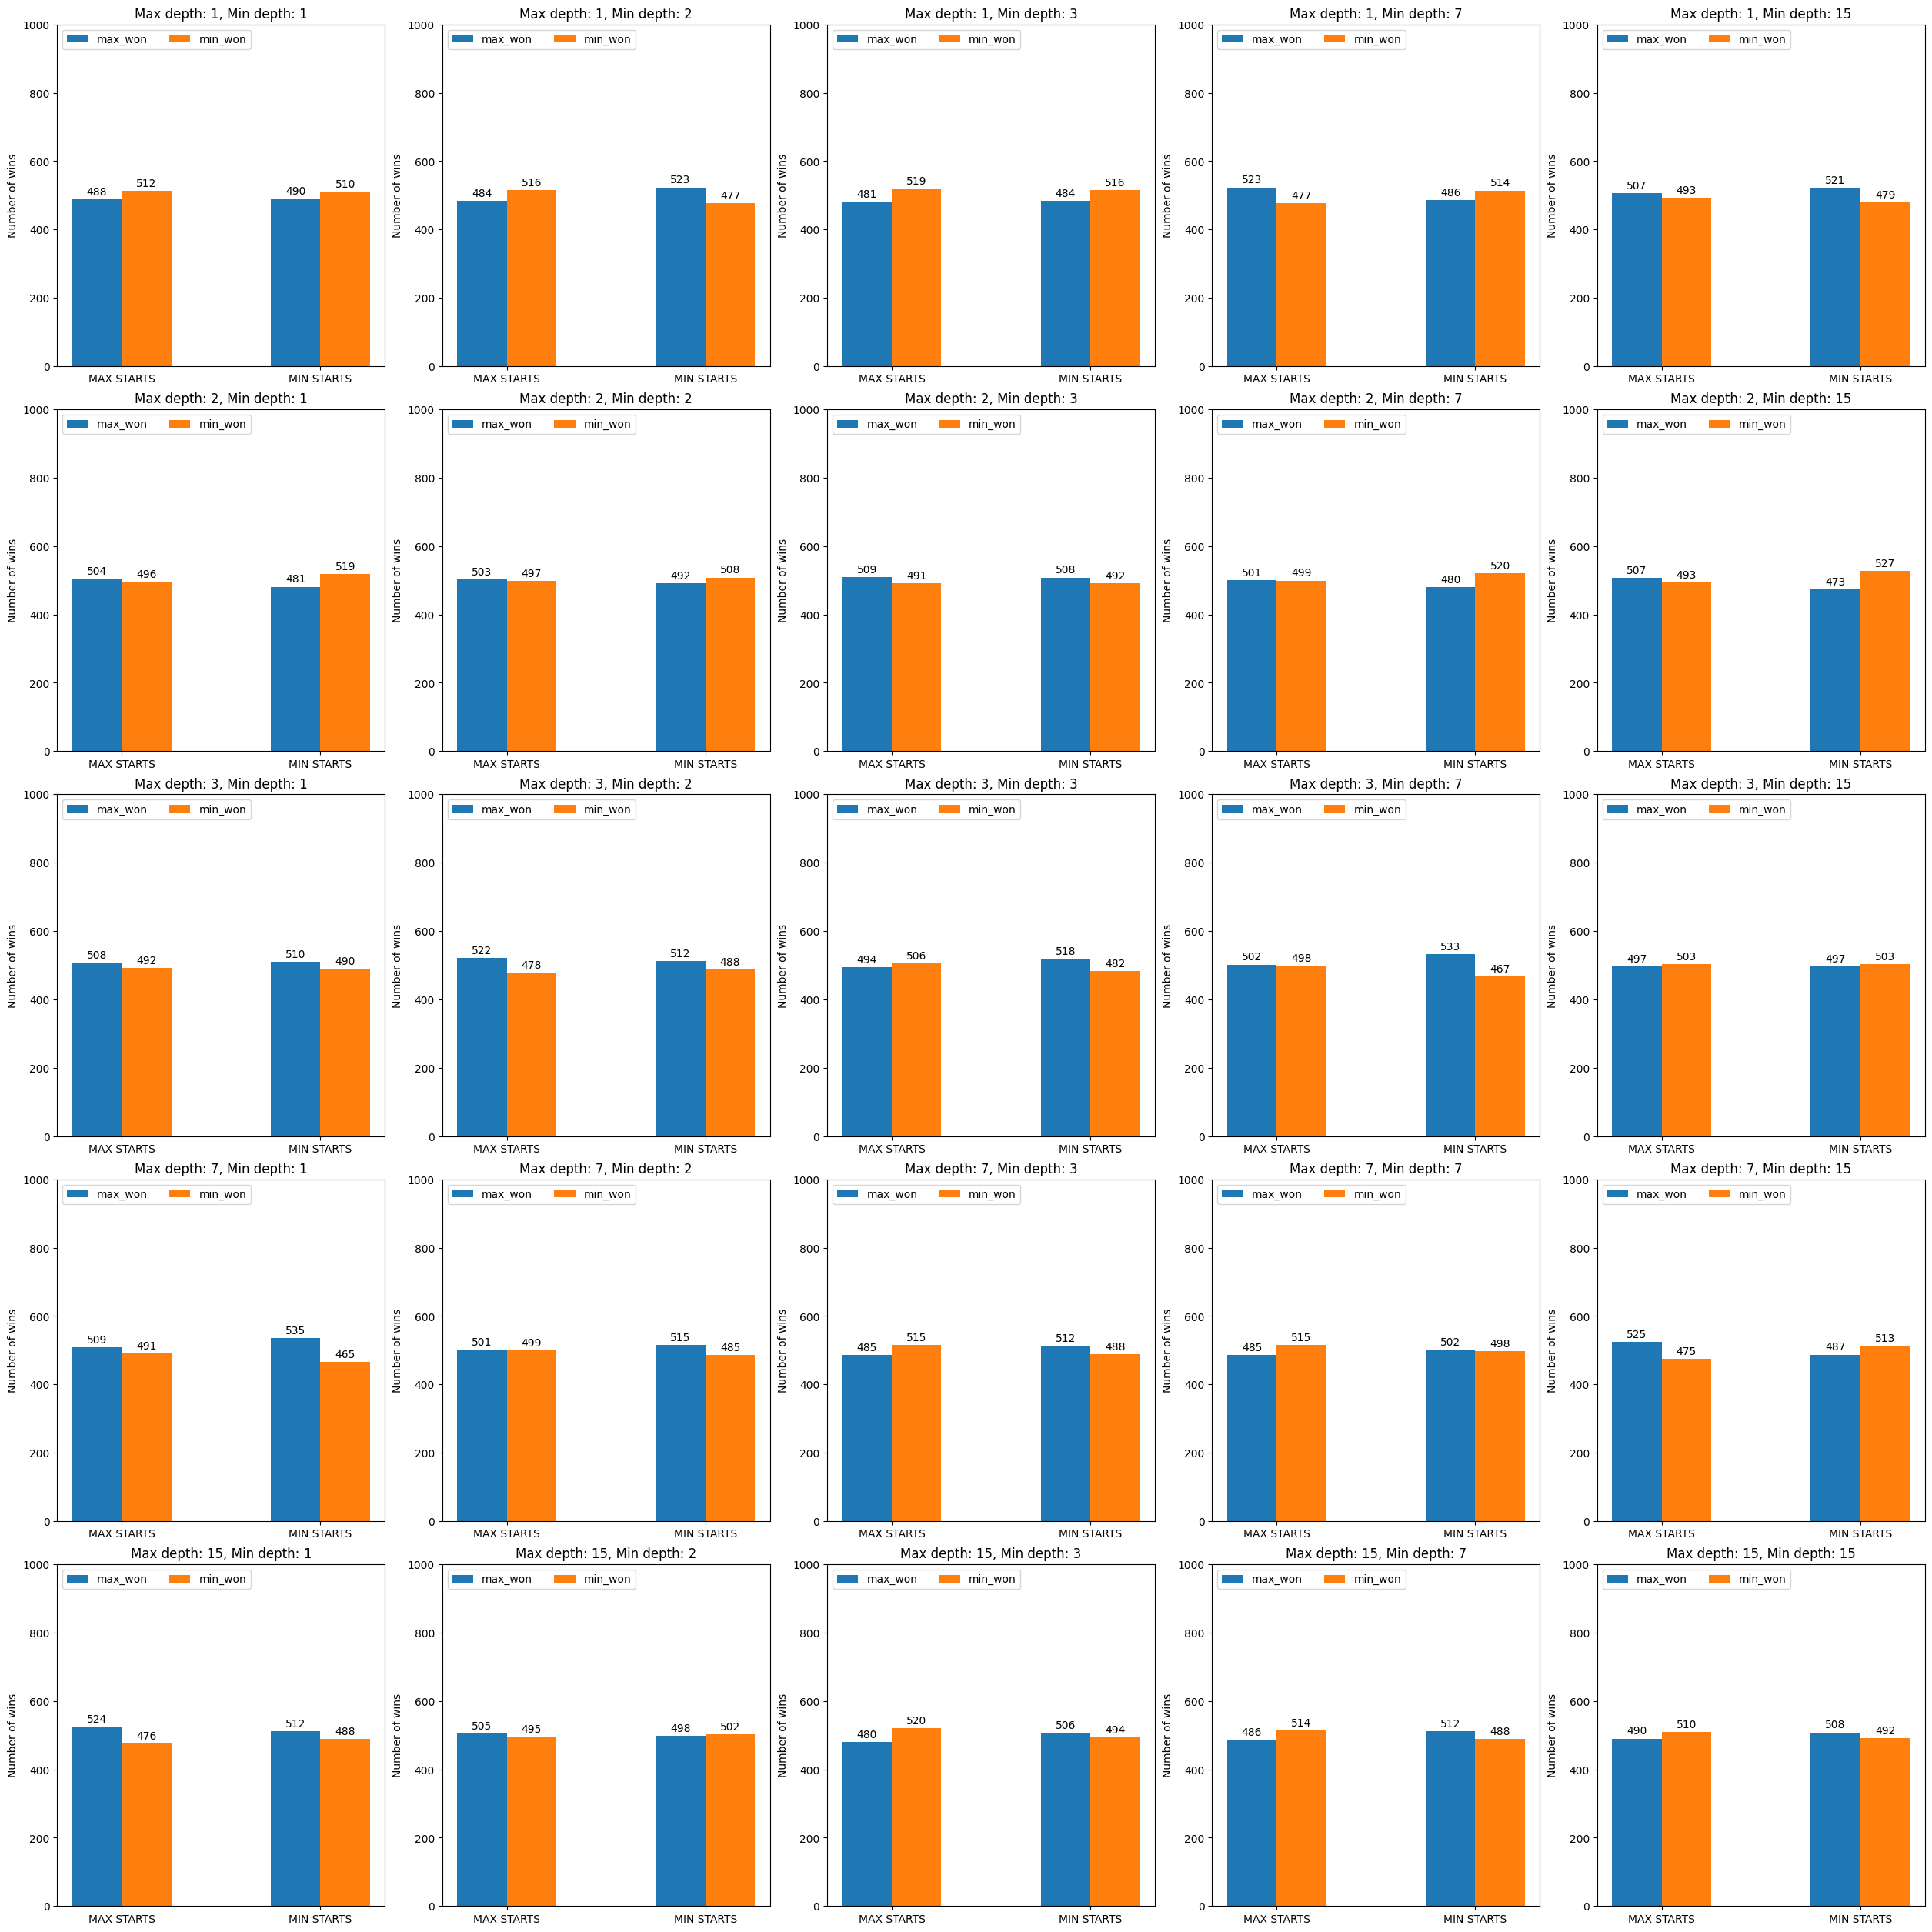

In [54]:
draw_graphs(random_heuristic, random_heuristic)

***Naive Heuristic vs Random Moves***

Upon comparing the naive heuristic with random move selection, a `significant advantage of using heuristics becomes apparent`. The Max player employing the heuristic `consistently won a higher percentage of games, ranging from 83% to 98%`, irrespective of whether they started the game. The difference in performance became more pronounced with increasing search depth for the player utilizing the heuristic. Greter the depth of heuristic, the better the performance.

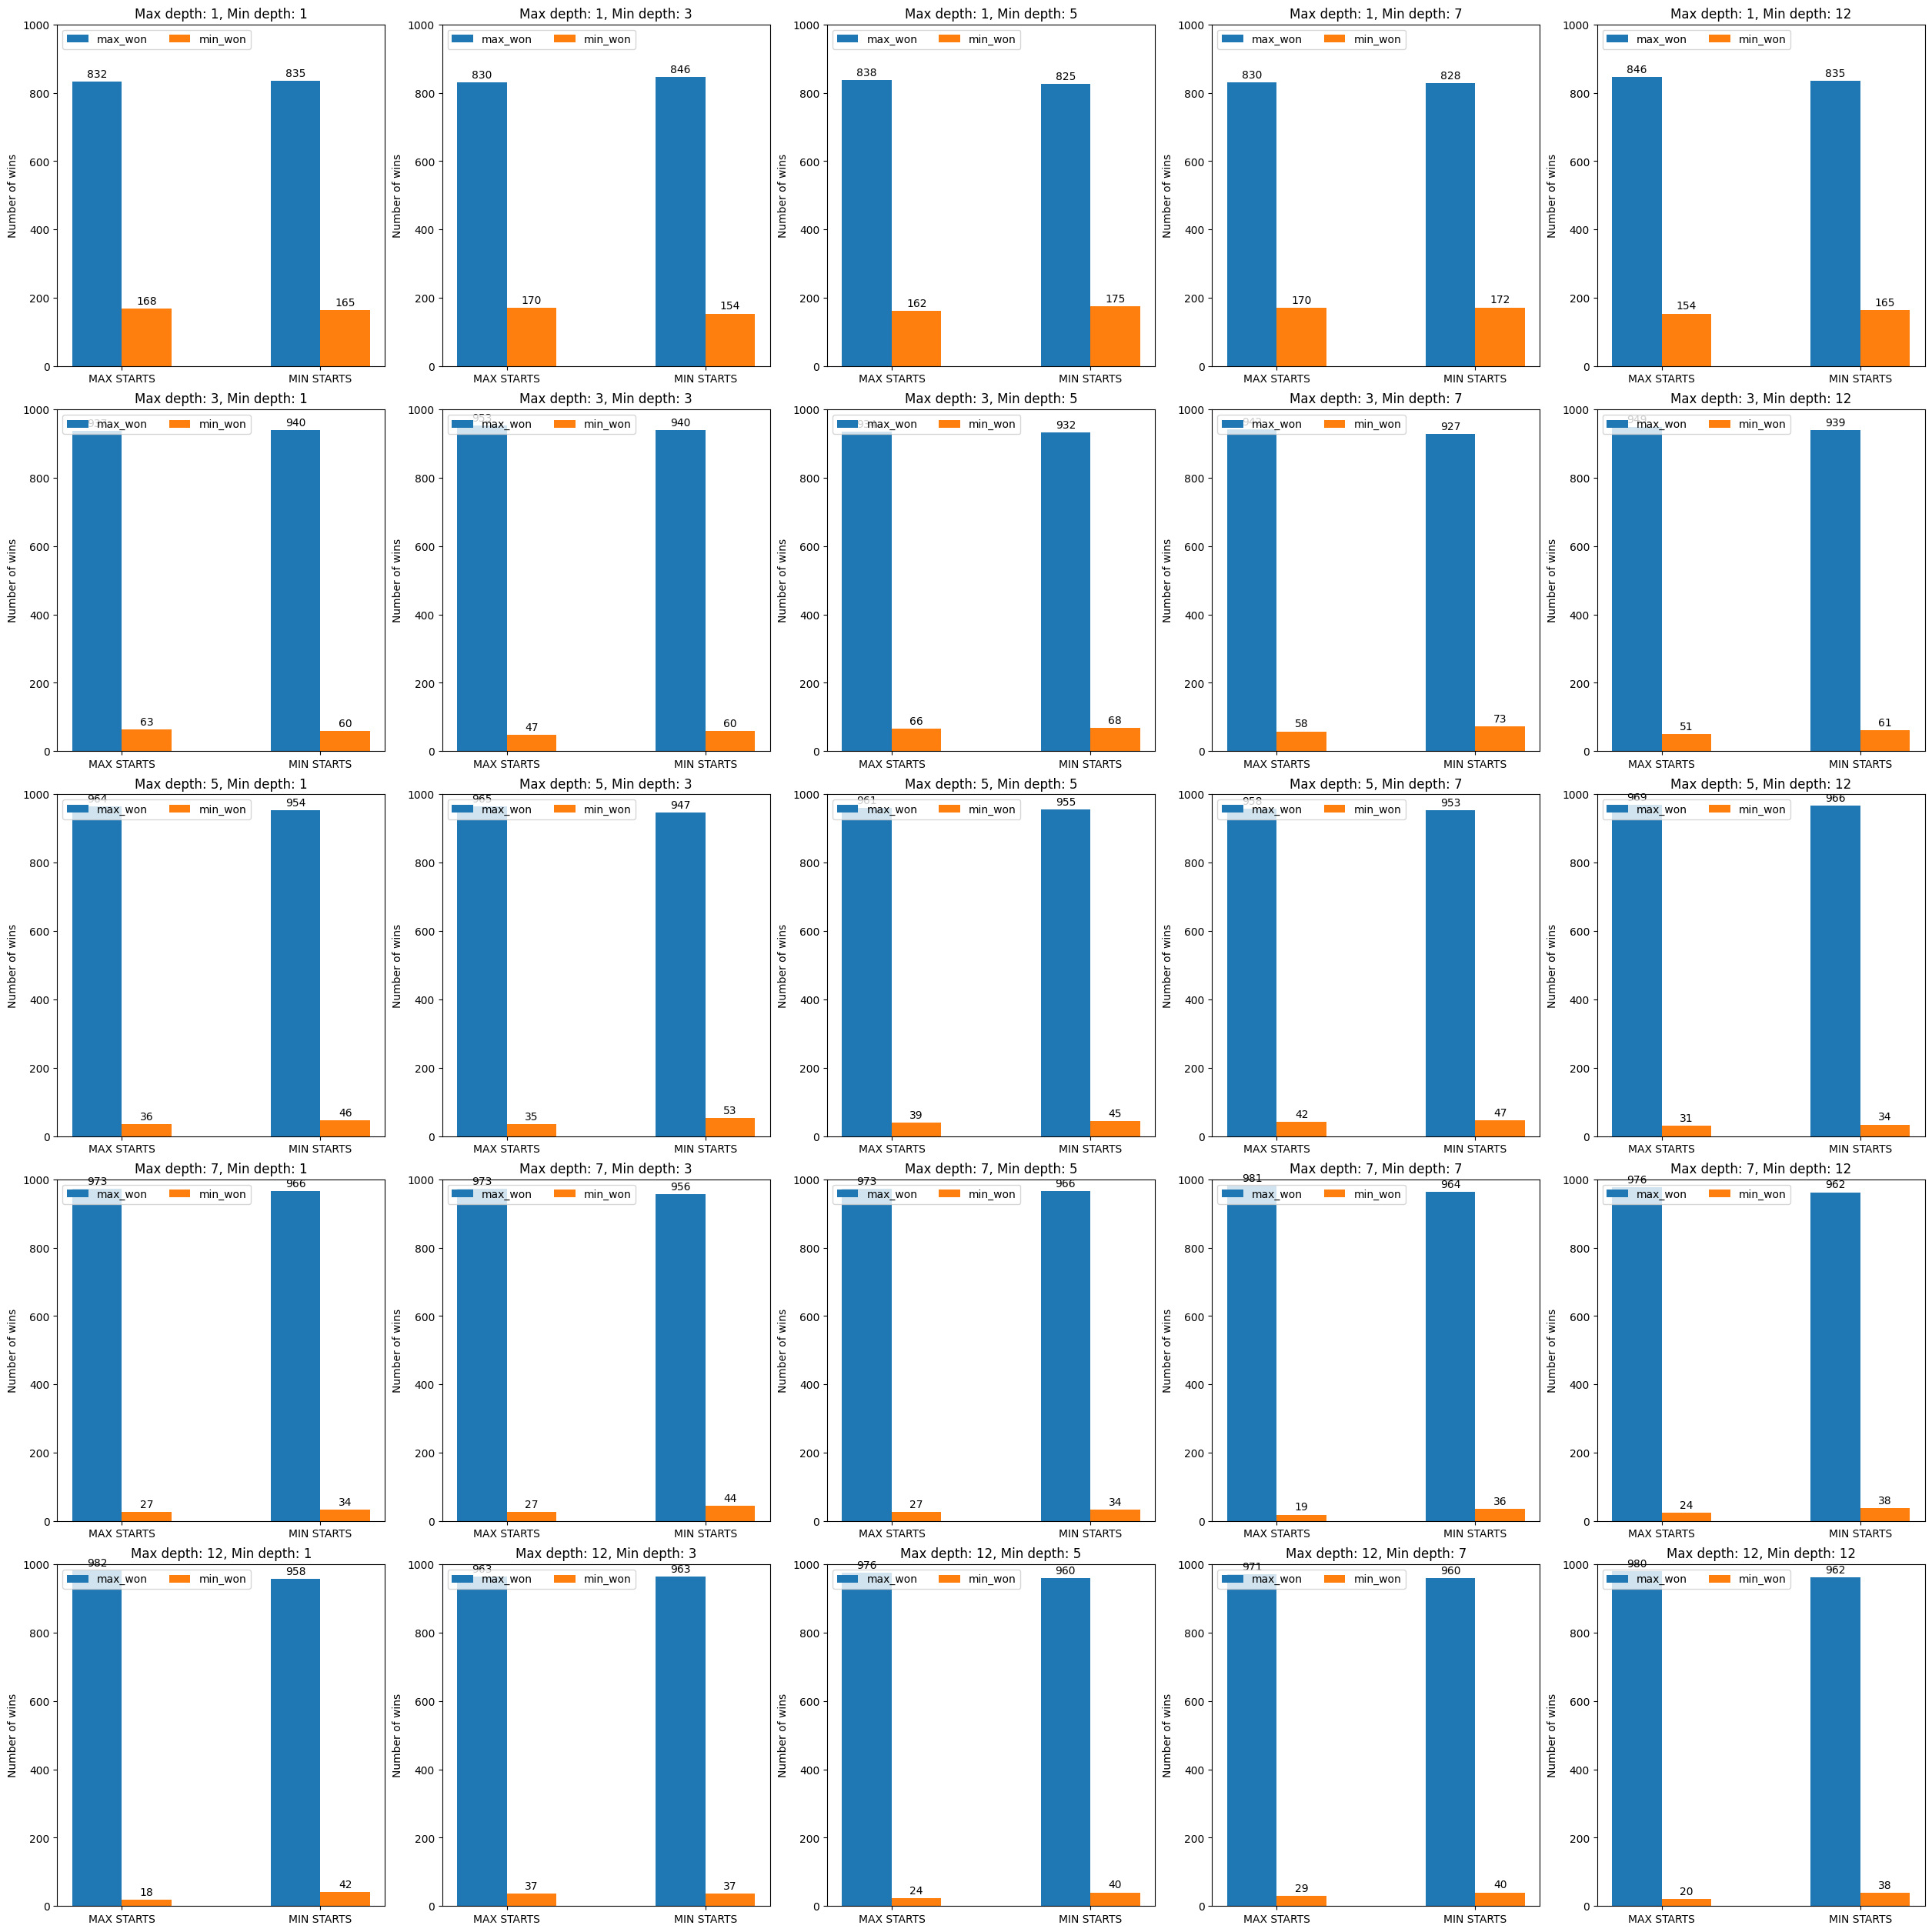

In [73]:
draw_graphs(naive_heuristic, random_heuristic)

***Comparison of My Heuristic and Naive Heuristic***

My heuristic wins most games in two cases:
- when the serach depth for `my heuristic is small (1, 2)` and the search depth for the `naive heuristic can be any value`
- when the serach depth for `my heuristic can be any value` but the search depth for the `naive heuristic must be small (1, 2)`

However, as the depth of both heuristics increases (larger than 2), the difference becomes less pronounced. For large depths, the charts resemble those of random gameplay. Who starts the game also does not significantly affect the number of wins. 

In [ ]:
draw_graphs(my_heuristic, naive_heuristic)

In [21]:
import ipytest
import pytest
ipytest.autoconfig()

In [27]:
def test_minimax_algorithm_max_starts():
    position = Position(4, 0, 0, None)
    cost = minimax(position, 1, -math.inf, math.inf, True, naive_heuristic, 4)
    assert cost == 1

def test_minimax_algorithm_min_starts():
    position = Position(4, 0, 0, None)
    cost = minimax(position, 1, -math.inf, math.inf, False, naive_heuristic, 4)
    assert cost == -1

def test_game_max_starts():
    game = Game(4, 0, 0, True, naive_heuristic, naive_heuristic)
    assert game.play() == 'Max won!'

def test_game_min_starts():
    game = Game(4, 0, 0, False, naive_heuristic, naive_heuristic)
    assert game.play() == 'Min won!'

ipytest.run()

....                                                                                         [100%]


4 passed in 0.02s


<ExitCode.OK: 0>